In [10]:
# !pip install lightgbm
!pip install tqdm

You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [1]:
import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')

In [2]:
import feather as ftr

train = ftr.read_dataframe("../data/input/train.feather")
test = ftr.read_dataframe("../data/input/test.feather")

In [3]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [12]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    #行列を入れ替える
    return(np.transpose(tt))

In [14]:
%%time
missing_data(train)

Wall time: 1.64 s


,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
Total,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Types,object,int64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [15]:
%%time
train.describe()

Wall time: 3.33 s


,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [17]:
%%time
test.describe()

Wall time: 3.23 s


,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,10.658737,-1.624244,10.707452,6.788214,11.076399,-5.050558,5.415164,16.529143,0.277135,7.569407,...,3.189766,7.458269,1.925944,3.322016,17.996967,-0.133657,2.290899,8.912428,15.869184,-3.246342
std,3.036716,4.040509,2.633888,2.052724,1.616456,7.869293,0.864686,3.424482,3.333375,1.231865,...,4.551239,3.025189,1.479966,3.995599,3.140652,1.429678,5.446346,0.920904,3.008717,10.398589
min,0.188700,-15.043400,2.355200,-0.022400,5.484400,-27.767000,2.216400,5.713700,-9.956000,4.243300,...,-14.093300,-2.407000,-3.340900,-11.413100,9.382800,-4.911900,-13.944200,6.169600,6.584000,-39.457800
25%,8.442975,-4.700125,8.735600,5.230500,9.891075,-11.201400,4.772600,13.933900,-2.303900,6.623800,...,-0.095000,5.166500,0.882975,0.587600,15.634775,-1.160700,-1.948600,8.260075,13.847275,-11.124000
50%,10.513800,-1.590500,10.560700,6.822350,11.099750,-4.834100,5.391600,16.422700,0.372000,7.632000,...,3.162400,7.379000,1.892600,3.428500,17.977600,-0.162000,2.403600,8.892800,15.943400,-2.725950
75%,12.739600,1.343400,12.495025,8.327600,12.253400,0.942575,6.005800,19.094550,2.930025,8.584825,...,6.336475,9.531100,2.956000,6.174200,20.391725,0.837900,6.519800,9.595900,18.045200,4.935400
max,22.323400,9.385100,18.714100,13.142000,16.037100,17.253700,8.302500,28.292800,9.665500,11.003600,...,20.359000,16.716500,8.005000,17.632600,27.947800,4.545400,15.920700,12.275800,26.538400,27.907400



- 標準偏差はtrain,testどちらも大きい 
- min,max,mean,stdどれもtrain,testどれも近い
- 各特徴量の平均値が全然違う




In [19]:
def plot_feature_scatter(df1, df2, features):
    i = 0
    #　背景を白にする
    sns.set_style('whitegrid')
    # 何も描画されない新しいウィンドウを作成する
    plt.figure()
    fig, ax = plt.subplots(4,4,figsize=(14,14))

    for feature in features:
        i += 1
        plt.subplot(4,4,i)
        plt.scatter(df1[feature], df2[feature], marker='+')
        plt.xlabel(feature, fontsize=9)
    plt.show();

<Figure size 432x288 with 0 Axes>

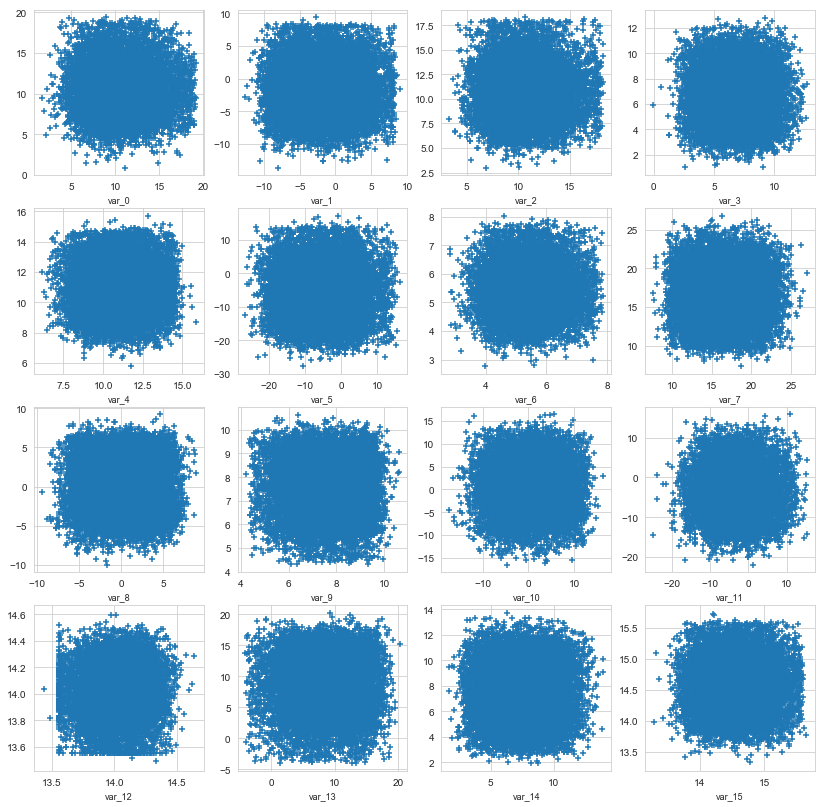

In [21]:
features = ['var_0', 'var_1','var_2','var_3', 'var_4', 'var_5', 'var_6', 'var_7', 
           'var_8', 'var_9', 'var_10','var_11','var_12', 'var_13', 'var_14', 'var_15', 
           ]
plot_feature_scatter(train[::20],test[::20], features)

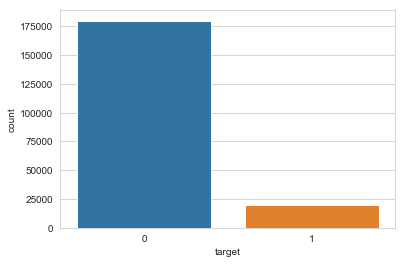

In [22]:
sns.countplot(train['target'])

In [24]:
print("There are {}% target values with 1".format(100 * train["target"].value_counts()[1]/train.shape[0]))

There are 10.049% target values with 1


In [5]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(10,10,figsize=(18,22))

    for feature in features:
        i += 1
        plt.subplot(10,10,i)
        sns.kdeplot(df1[feature], bw=0.5,label=label1)
        sns.kdeplot(df2[feature], bw=0.5,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show();

<Figure size 432x288 with 0 Axes>

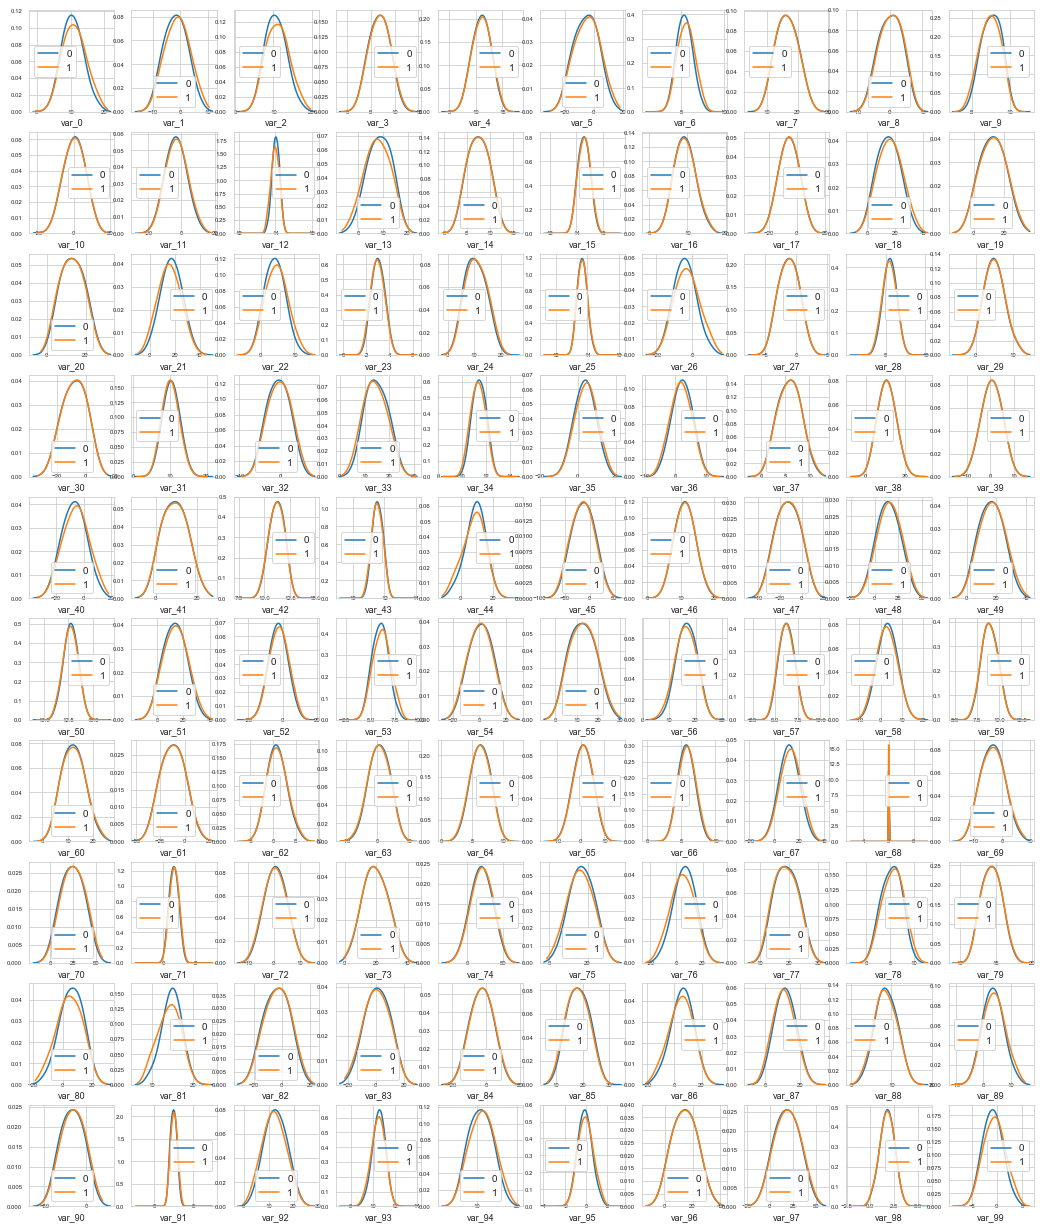

In [6]:
t0 = train.loc[train['target'] == 0]
t1 = train.loc[train['target'] == 1]
features = train.columns.values[2:102]
plot_feature_distribution(t0, t1, '0', '1', features)

<Figure size 432x288 with 0 Axes>

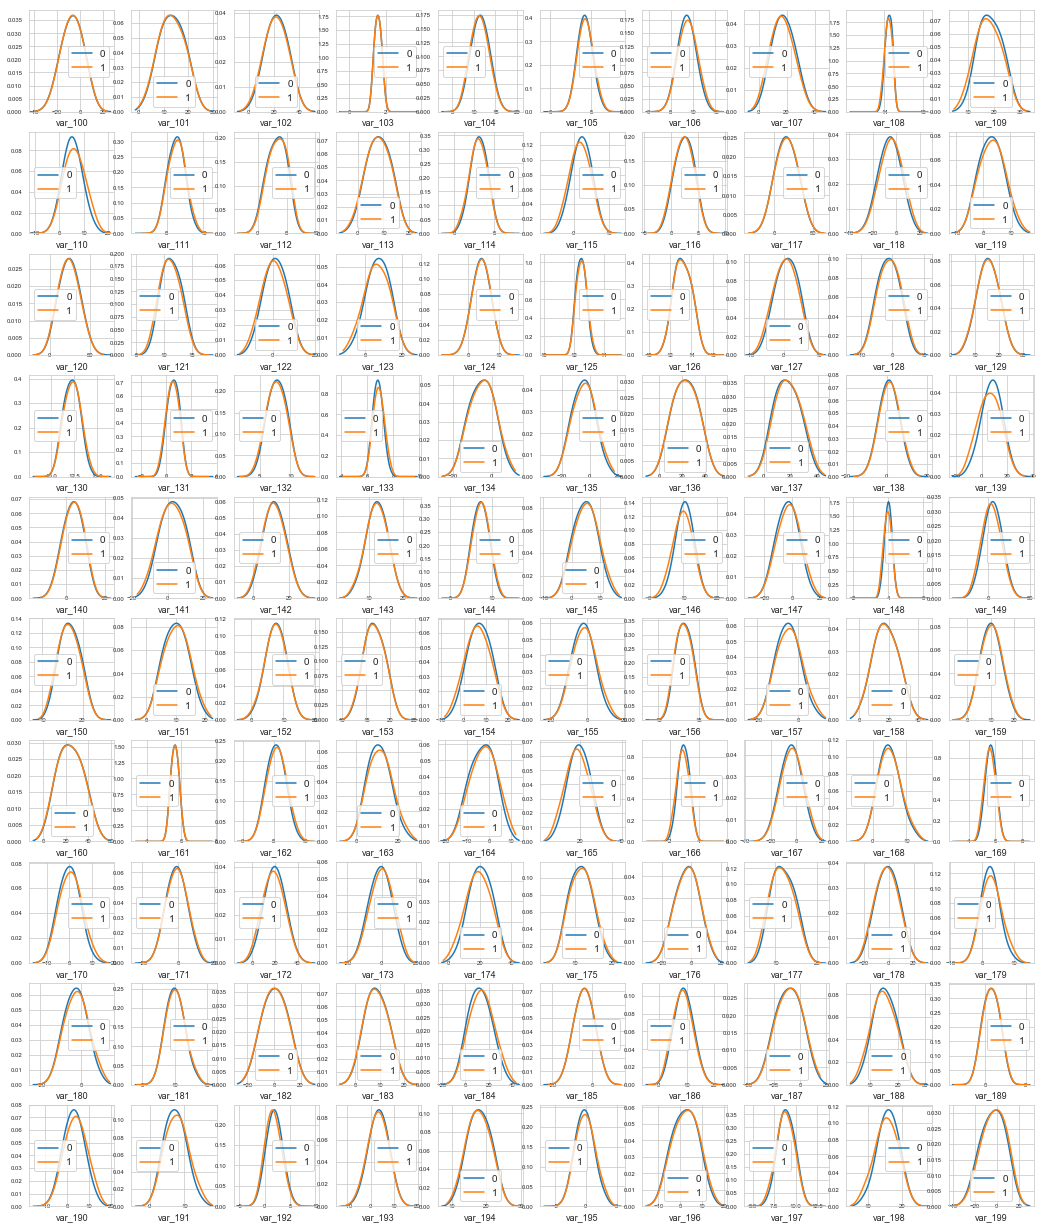

In [7]:
features = train.columns.values[102:]
plot_feature_distribution(t0, t1, '0', '1', features)

-  var_0, var_1, var_2, var_5, var_9, var_13, var_106, var_109, var_139 等は０と１の分布が大きく異なる<br>
- var_2, var_13, var_26, var_55, var_175, var_184, var_196等は分布が正規分布（？）に従うように再調整されている

trainとtest毎に各行・列の要素の値の平均・分散がどのように分布されているか確認する

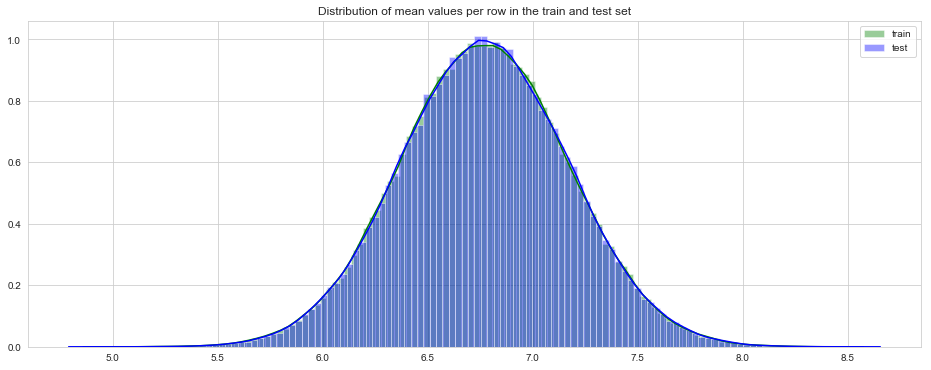

In [10]:
plt.figure(figsize=(16,6))
features = train.columns.values[2:202]
plt.title("Distribution of mean values per row in the train and test set")
#kdeも表示する。120分割する
sns.distplot(train[features].mean(axis=1),color="green", kde=True,bins=120, label='train')
sns.distplot(test[features].mean(axis=1),color="blue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

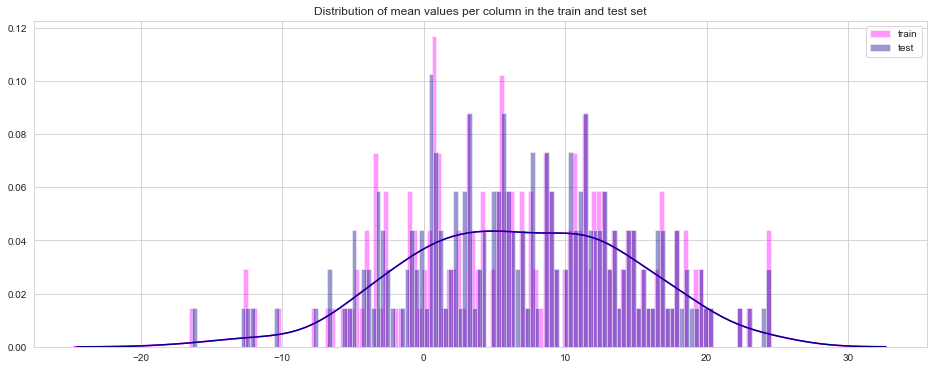

In [12]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train and test set")
sns.distplot(train[features].mean(axis=0),color="magenta",kde=True,bins=120, label='train')
sns.distplot(test[features].mean(axis=0),color="darkblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

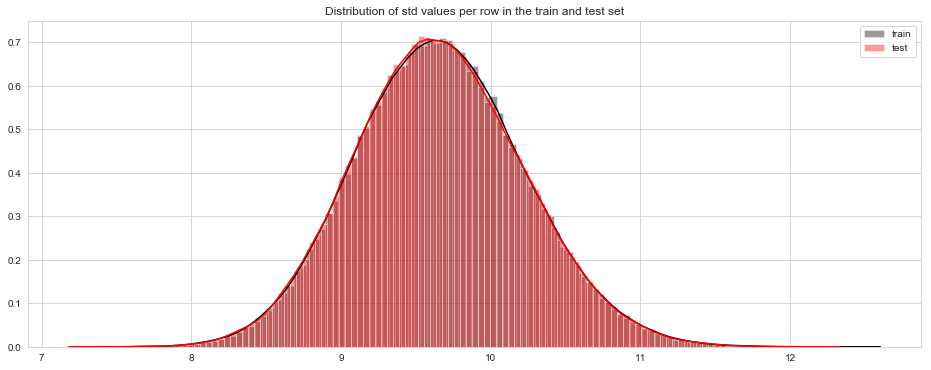

In [15]:
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per row in the train and test set")
sns.distplot(train[features].std(axis=1),color="black", kde=True,bins=120, label='train')
sns.distplot(test[features].std(axis=1),color="red", kde=True,bins=120, label='test')
plt.legend();plt.show()

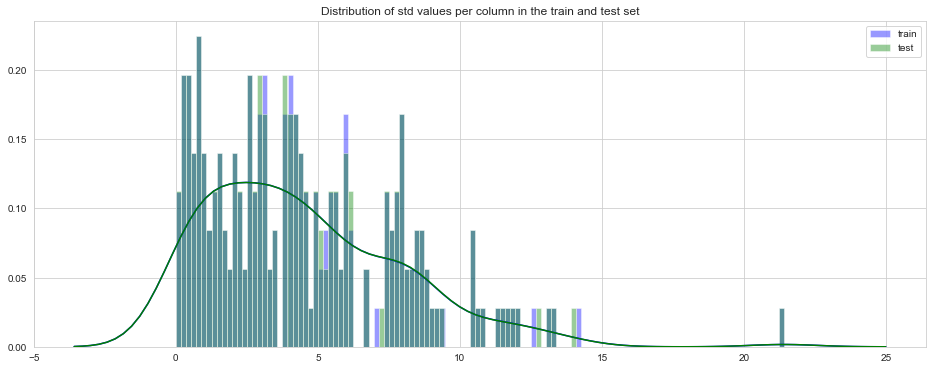

In [16]:
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per column in the train and test set")
sns.distplot(train[features].std(axis=0),color="blue",kde=True,bins=120, label='train')
sns.distplot(test[features].std(axis=0),color="green", kde=True,bins=120, label='test')
plt.legend(); plt.show()

targetによって分割し、平均・分散を確認する

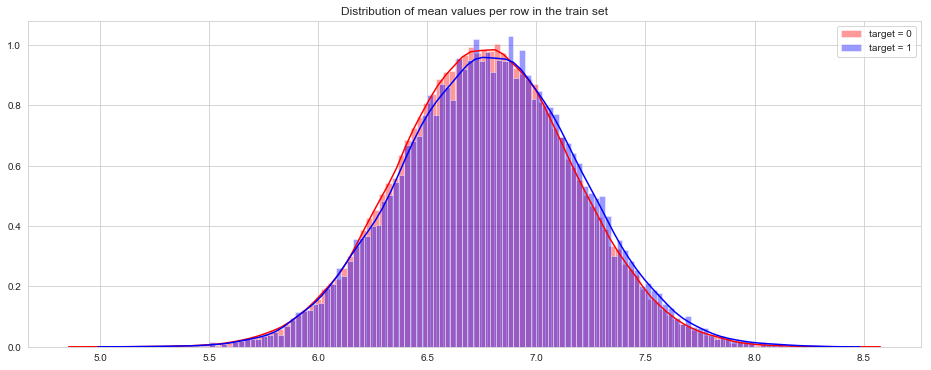

In [18]:
t0 = train.loc[train['target'] == 0]
t1 = train.loc[train['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per row in the train set")
sns.distplot(t0[features].mean(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].mean(axis=1),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

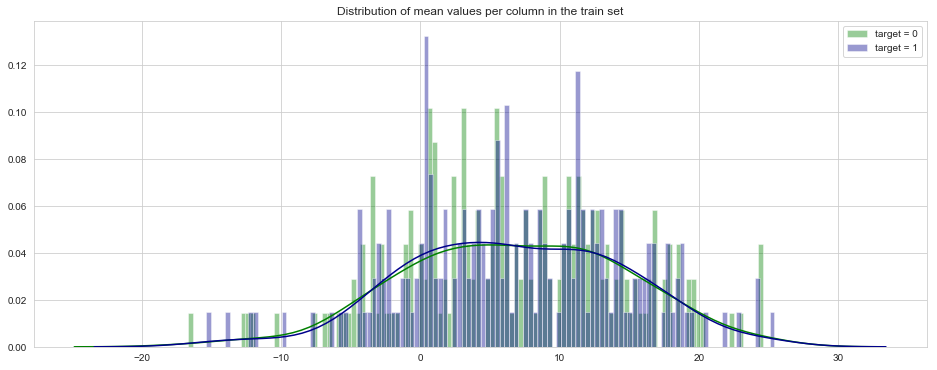

In [19]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train set")
sns.distplot(t0[features].mean(axis=0),color="green", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].mean(axis=0),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

trainとtest毎に各行・列の要素の値の最小値・最大値がどのように分布されているか確認する

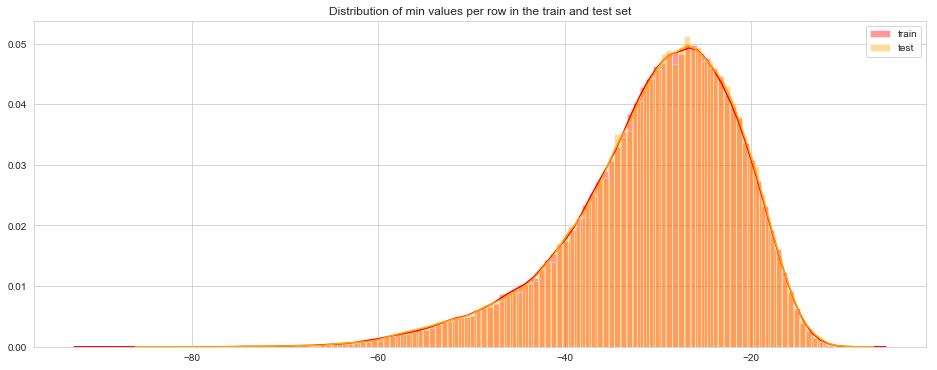

In [23]:
plt.figure(figsize=(16,6))
features = train.columns.values[2:202]
plt.title("Distribution of min values per row in the train and test set")
sns.distplot(train[features].min(axis=1),color="red", kde=True,bins=120, label='train')
sns.distplot(test[features].min(axis=1),color="orange", kde=True,bins=120, label='test')
plt.legend()
plt.show()

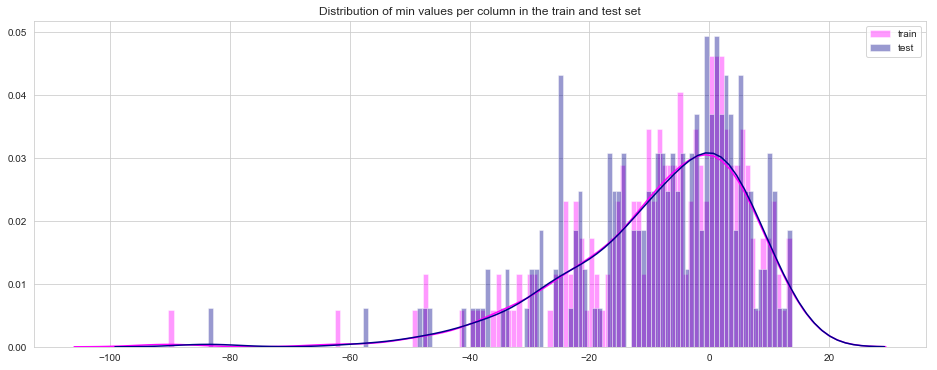

In [26]:
plt.figure(figsize=(16,6))
features = train.columns.values[2:202]
plt.title("Distribution of min values per column in the train and test set")
sns.distplot(train[features].min(axis=0),color="magenta", kde=True,bins=120, label='train')
sns.distplot(test[features].min(axis=0),color="darkblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

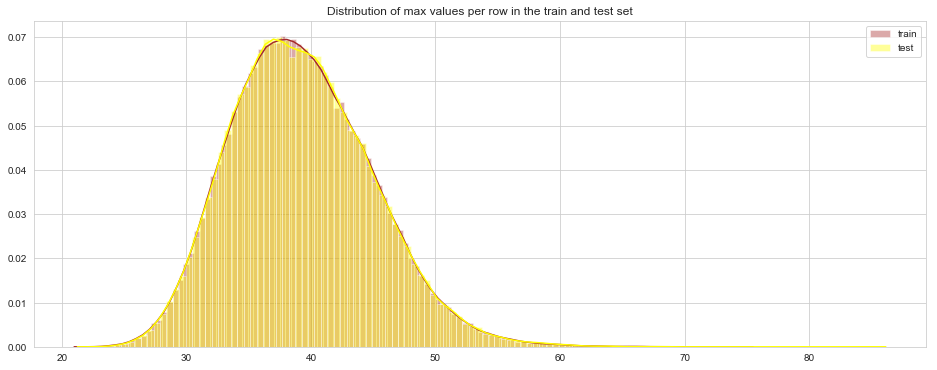

In [27]:
plt.figure(figsize=(16,6))
features = train.columns.values[2:202]
plt.title("Distribution of max values per row in the train and test set")
sns.distplot(train[features].max(axis=1),color="brown", kde=True,bins=120, label='train')
sns.distplot(test[features].max(axis=1),color="yellow", kde=True,bins=120, label='test')
plt.legend()
plt.show()

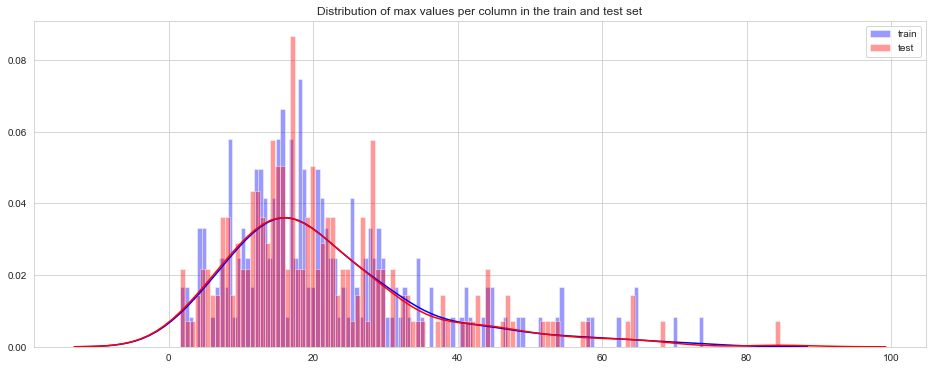

In [28]:
plt.figure(figsize=(16,6))
features = train.columns.values[2:202]
plt.title("Distribution of max values per column in the train and test set")
sns.distplot(train[features].max(axis=0),color="blue", kde=True,bins=120, label='train')
sns.distplot(test[features].max(axis=0),color="red", kde=True,bins=120, label='test')
plt.legend()
plt.show()

targetごとにminmaxを確認する

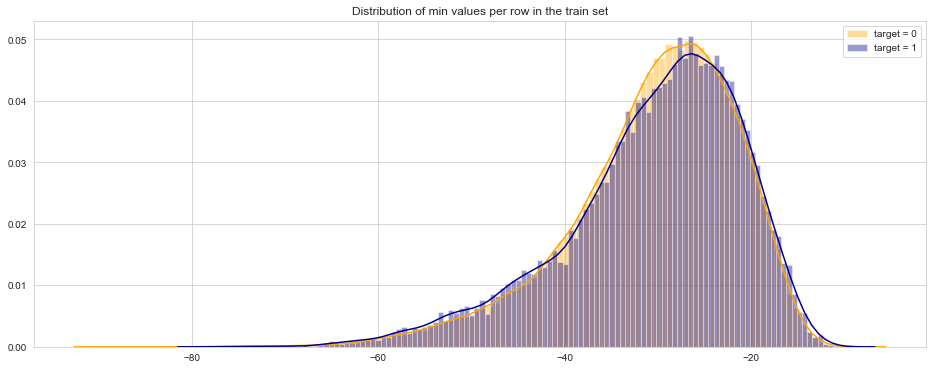

In [29]:
t0 = train.loc[train['target'] == 0]
t1 = train.loc[train['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of min values per row in the train set")
sns.distplot(t0[features].min(axis=1),color="orange", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].min(axis=1),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

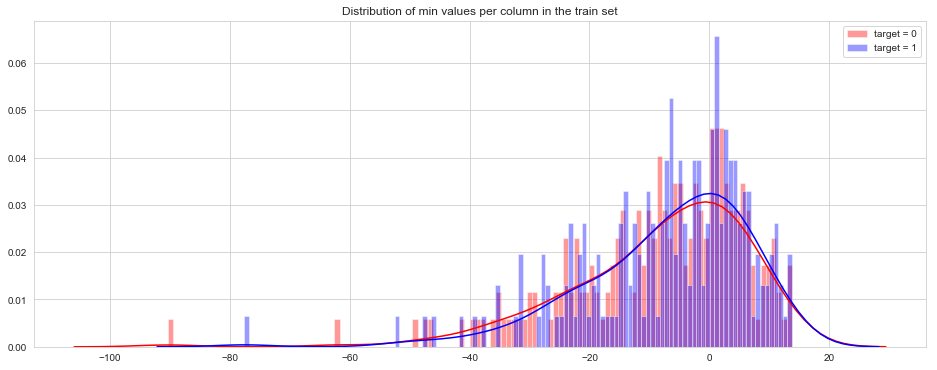

In [30]:
plt.figure(figsize=(16,6))
plt.title("Distribution of min values per column in the train set")
sns.distplot(t0[features].min(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].min(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

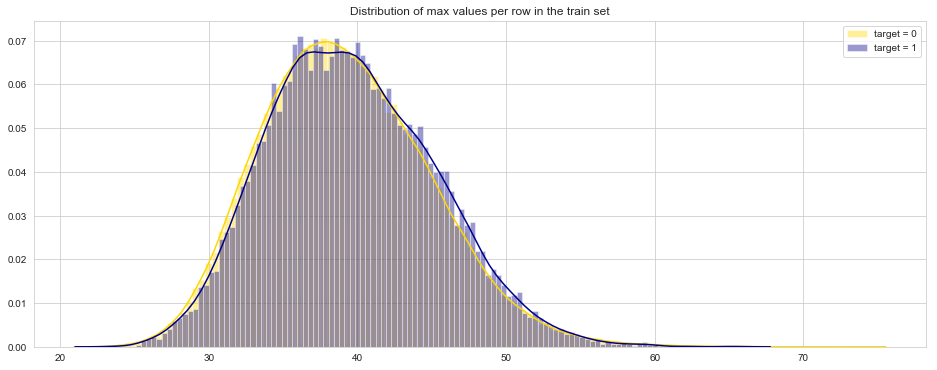

In [32]:
plt.figure(figsize=(16,6))
plt.title("Distribution of max values per row in the train set")
sns.distplot(t0[features].max(axis=1),color="gold", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].max(axis=1),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

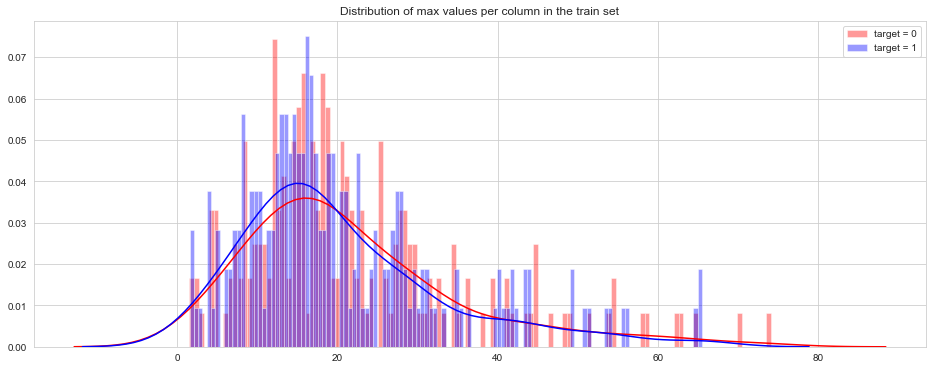

In [31]:
plt.figure(figsize=(16,6))
plt.title("Distribution of max values per column in the train set")
sns.distplot(t0[features].max(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].max(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

歪度と尖度を確認する(skewness,kurtosis)

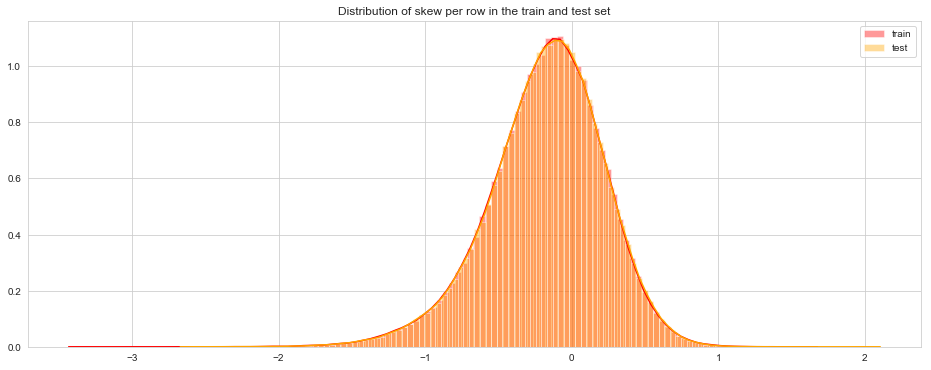

In [36]:
plt.figure(figsize=(16,6))
plt.title("Distribution of skew per row in the train and test set")
sns.distplot(train[features].skew(axis=1),color="red", kde=True,bins=120, label='train')
sns.distplot(test[features].skew(axis=1),color="orange", kde=True,bins=120, label='test')
plt.legend()
plt.show()

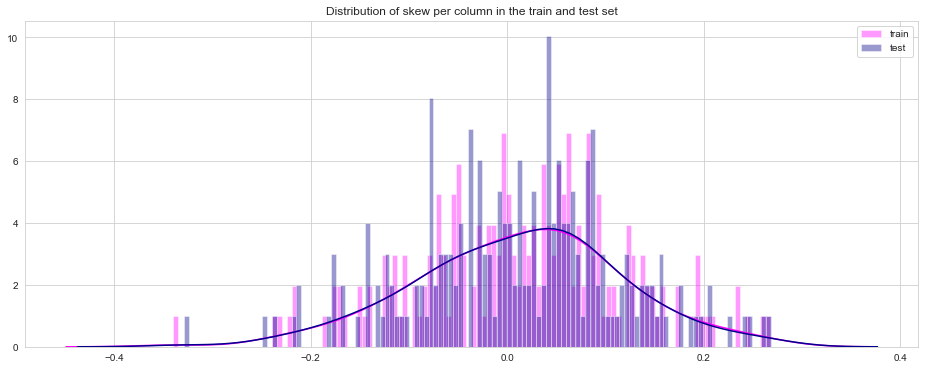

In [37]:
plt.figure(figsize=(16,6))
plt.title("Distribution of skew per column in the train and test set")
sns.distplot(train[features].skew(axis=0),color="magenta", kde=True,bins=120, label='train')
sns.distplot(test[features].skew(axis=0),color="darkblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

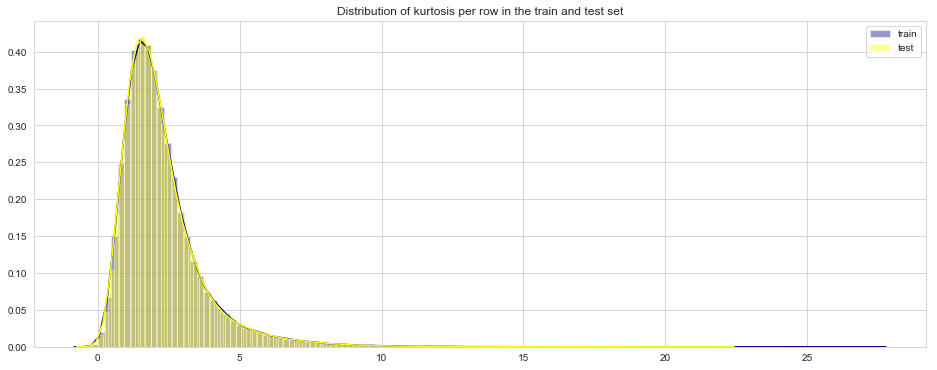

In [38]:
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis per row in the train and test set")
sns.distplot(train[features].kurtosis(axis=1),color="darkblue", kde=True,bins=120, label='train')
sns.distplot(test[features].kurtosis(axis=1),color="yellow", kde=True,bins=120, label='test')
plt.legend()
plt.show()

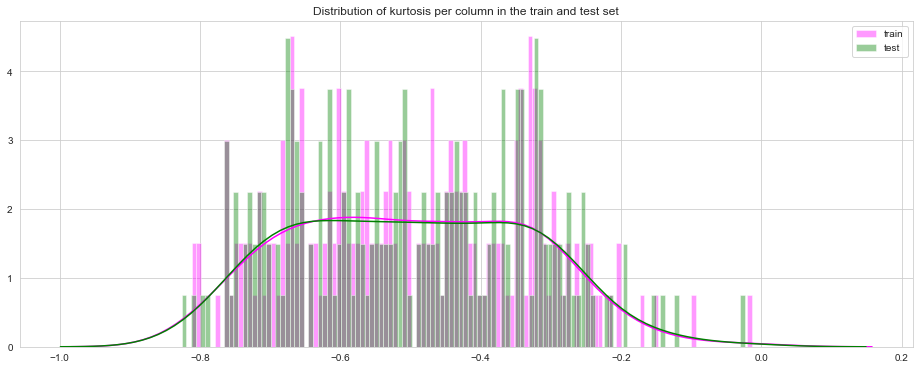

In [39]:
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis per column in the train and test set")
sns.distplot(train[features].kurtosis(axis=0),color="magenta", kde=True,bins=120, label='train')
sns.distplot(test[features].kurtosis(axis=0),color="green", kde=True,bins=120, label='test')
plt.legend()
plt.show()

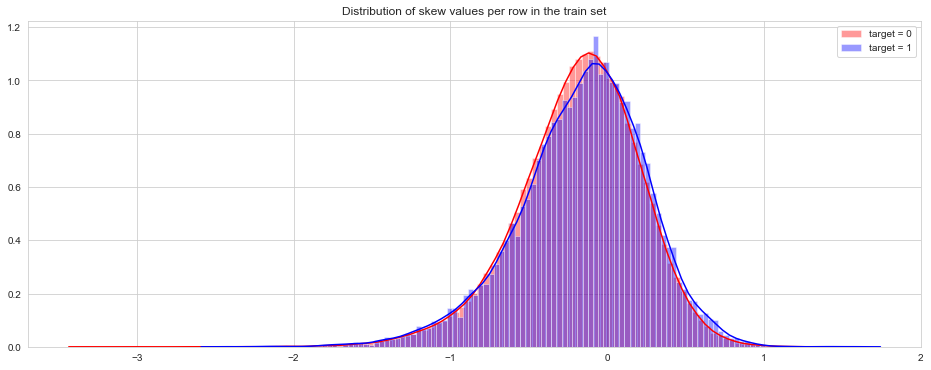

In [41]:
t0 = train.loc[train['target'] == 0]
t1 = train.loc[train['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of skew values per row in the train set")
sns.distplot(t0[features].skew(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].skew(axis=1),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

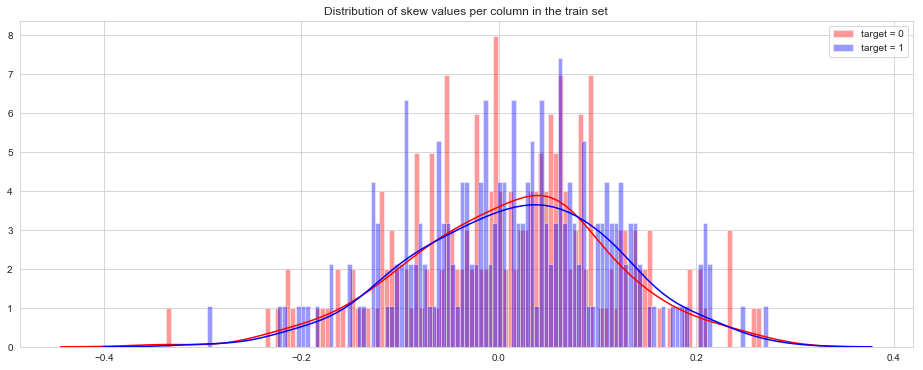

In [42]:
plt.figure(figsize=(16,6))
plt.title("Distribution of skew values per column in the train set")
sns.distplot(t0[features].skew(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].skew(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

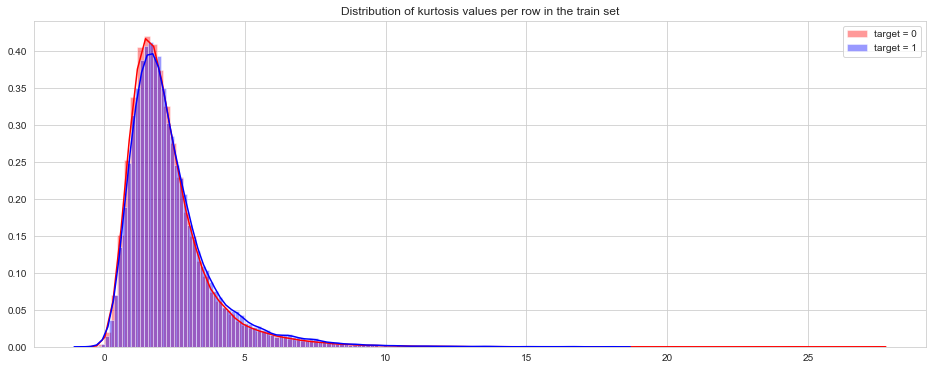

In [43]:
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis values per row in the train set")
sns.distplot(t0[features].kurtosis(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].kurtosis(axis=1),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

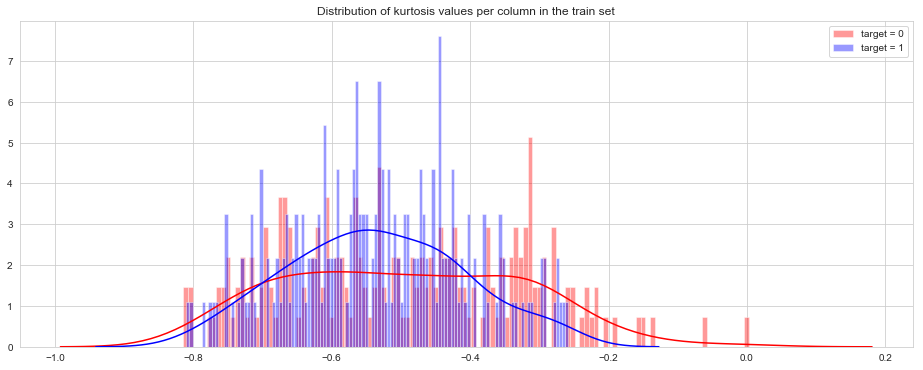

In [44]:
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis values per column in the train set")
sns.distplot(t0[features].kurtosis(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].kurtosis(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

### 特徴量の相関を確認していく。

In [46]:
%%time
correlations = train[features].corr().abs().unstack().sort_values(kind="quicksort").reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']]
correlations.head(10)

Wall time: 13.5 s


In [47]:
correlations.tail(10)

,level_0,level_1,0
39790,var_183,var_189,0.009359
39791,var_189,var_183,0.009359
39792,var_174,var_81,0.009490
39793,var_81,var_174,0.009490
39794,var_81,var_165,0.009714
39795,var_165,var_81,0.009714
39796,var_53,var_148,0.009788
39797,var_148,var_53,0.009788
39798,var_26,var_139,0.009844
39799,var_139,var_26,0.009844


### 重複の多い特徴量を確認する。

In [49]:
features = train.columns.values[2:202]
unique_max_train = []
unique_max_test = []
for feature in features:
    values = train[feature].value_counts()
    unique_max_train.append([feature, values.max(), values.idxmax()])
    values = test[feature].value_counts()
    unique_max_test.append([feature, values.max(), values.idxmax()])

In [50]:
np.transpose((pd.DataFrame(unique_max_train, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head(15))

,68,108,126,12,91,103,148,71,161,25,125,169,166,133,43
Feature,var_68,var_108,var_126,var_12,var_91,var_103,var_148,var_71,var_161,var_25,var_125,var_169,var_166,var_133,var_43
Max duplicates,1084,313,305,203,66,61,59,54,52,41,40,39,39,39,39
Value,5.0214,14.1999,11.5356,13.5545,6.9785,1.6662,4.0456,0.7031,5.7688,13.6723,12.5159,5.6941,2.7306,6.8632,11.4522


In [ ]:
np.transpose((pd.DataFrame(unique_max_test, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head(15))

In [9]:
features = train.columns.values[2:202]
train[feature].value_counts()

NameError: name 'feature' is not defined

In [ ]:
uniques_train
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)